In [ ]:
%%capture
!pip install accelerate langchain_community pypdf einops xformers bitsandbytes sentence_transformers chromadb

In [ ]:
from torch import cuda, bfloat16
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from langchain.llms import HuggingFacePipeline
from langchain.document_loaders import DirectoryLoader, PyPDFLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA, RetrievalQAWithSourcesChain
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from diffusers import StableDiffusionPipeline

In [ ]:
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
print(device)

In [ ]:
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)
# Load 4-bit quantized model
model_id = "meta-llama/Llama-3.2-1B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,
)
model.config.use_cache = False
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
query_pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.float16,
        max_length=200,
        device_map="auto",)

In [ ]:
def test_model(tokenizer, pipeline, message):
    sequences = pipeline(
        message,
        do_sample=True,
        top_k=10,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        max_length=200,)

    question = sequences[0]['generated_text'][:len(message)]
    answer = sequences[0]['generated_text'][len(message):]

    return f"Question: {question}\nAnswer: {answer}"

In [ ]:
llm = HuggingFacePipeline(pipeline=query_pipeline)

In [ ]:
# Load all archive files in one text loader and split into chunks
path = "/content"
loader = DirectoryLoader(path, glob='**/*.txt', loader_cls=TextLoader)
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=50)
all_splits = text_splitter.split_documents(documents)

In [ ]:
# Load Embedding model and index the chunks in vector store
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cuda"}

embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)

vectordb = Chroma.from_documents(documents=all_splits, embedding=embeddings, persist_directory="chroma_db")
retriever = vectordb.as_retriever()

In [ ]:
# custom prompt for generating image description conditioned on retrieved chunks
baseline_chain_template = """
Use the following pieces of context to imagine an image description that would describe it. Use maximum 25 words in your description.

Context = {context}
Image Description:
"""

template_prompt = PromptTemplate(template = baseline_chain_template, input_variables=['context'])

qa = RetrievalQA.from_chain_type(llm =llm,
                                 chain_type = "stuff",
                                 retriever = retriever,
                                 chain_type_kwargs={
                                     "prompt": template_prompt})

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


  0%|          | 0/50 [00:00<?, ?it/s]

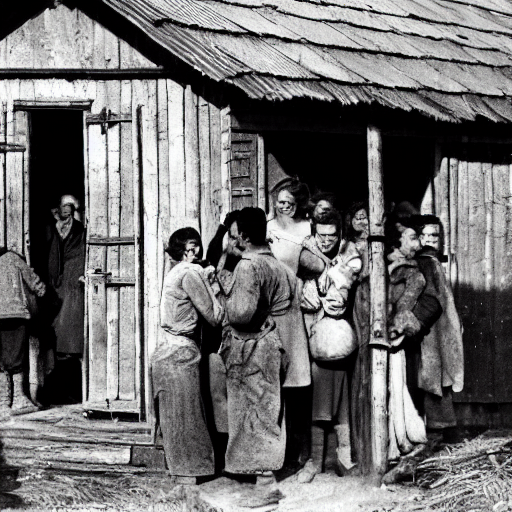

In [ ]:
query = "How did the forced labor camp look like"
response = qa.run(query)
prompt = response.split('Description:\n',1)[1]
base = "1940, Germany, forced labor, realistic, "
image = pipe(base + prompt).images[0]
image

In [ ]:
# For checking the retrieved documents
docs = vectordb.similarity_search(query)
print(f"Query: {query}")
print(f"Retrieved documents: {len(docs)}")
for doc in docs:
    doc_details = doc.to_json()['kwargs']
    print("Source: ", doc_details['metadata']['source'])
    print("Text: ", doc_details['page_content'], "\n")

Query: How did the forced labor camp look like
Retrieved documents: 4
Source:  /content/archive2.txt
Text:  big huts, wooden one, and each probably contain up to 200, 300 people. So that’s mean the camp was very big, and I believe that camp was newly built, 

Source:  /content/archive2.txt
Text:  The, ah, you gave us a really detailed description of the beginning of the forced labour. I was just wondering about the liberation, when forced 

Source:  /content/archive1.txt
Text:  because we … the work was always done outside. In the camp nobody was allowed to remain. 

Source:  /content/archive2.txt
Text:  There was little pay, you know, and was very hard to live. And in a village there was Ger... station, German commander in a school, and, ah, there was another building which was like community 

